In [53]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.18.0


### Load and explore NER data set

In [26]:
from google.colab import files
uploaded = files.upload()

Saving ner_dataset.csv to ner_dataset.csv


In [27]:
# @title Default title text
df = pd.read_csv('ner_dataset.csv', encoding='latin1')
df = df.fillna(method='ffill')
df.head(20)

<ipython-input-27-4a3e9f6b51fc>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [28]:
print('Unique words in corpus: ', df['Word'].nunique())
print('Unique tags in corpus: ', df['Tag'].nunique())

Unique words in corpus:  35177
Unique tags in corpus:  17


In [29]:
words = list(set(df['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [30]:
tags = list(set(df['Tag'].values))
num_tags = len(tags)

In [31]:
num_words, num_tags

(35178, 17)

### Retrieve sentences and corresponding tags

In [32]:
class SentenceGetter(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                          s['POS'].values.tolist(),
                                                          s['Tag'].values.tolist())]
        self.grouped = self.df.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [33]:
getter = SentenceGetter(df)
sentences = getter.sentences

<ipython-input-32-7eb3e8a87371>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.df.groupby('Sentence #').apply(agg_func)


In [34]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Define mappings between sentences and tags

In [35]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

### Padding input sentences and creating train/test split

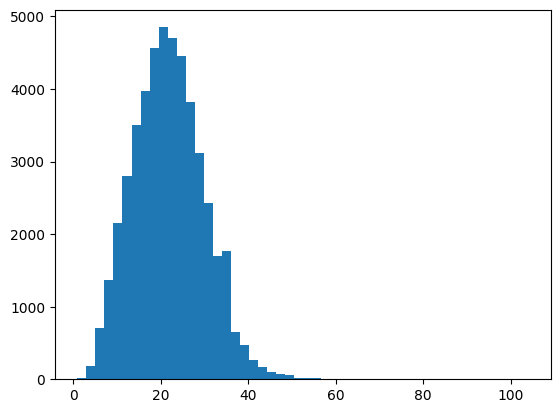

In [39]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show();

In [40]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [41]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Build and compile a Bidirectional LSTM model

In [42]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [43]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 50)         │     1,758,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 50, 50)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 200)        │       120,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 17)         │         3,417 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,883,117 (7.18 MB)

 Trainable params: 1,883,117 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
!pip install livelossplot

### Train the model

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [54]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 3,
    verbose = 1,
#    callbacks = callbacks
)

Epoch 1/3
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 301s 268ms/step - accuracy: 0.9413 - loss: 0.3131 - val_accuracy: 0.9827 - val_loss: 0.0588
Epoch 2/3
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 322s 271ms/step - accuracy: 0.9849 - loss: 0.0514 - val_accuracy: 0.9852 - val_loss: 0.0486
Epoch 3/3
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 321s 271ms/step - accuracy: 0.9890 - loss: 0.0368 - val_accuracy: 0.9859 - val_loss: 0.0458


### Evaluate Named Entity Recognition model

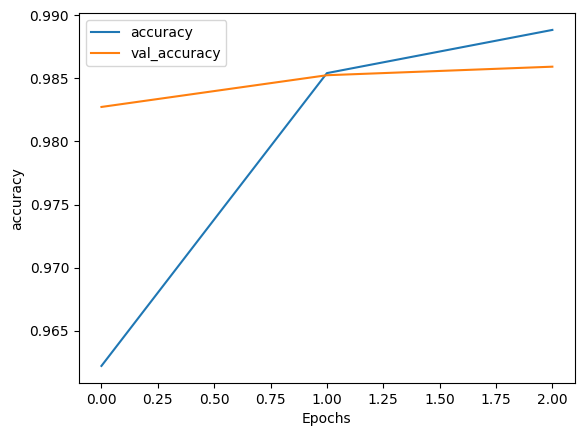

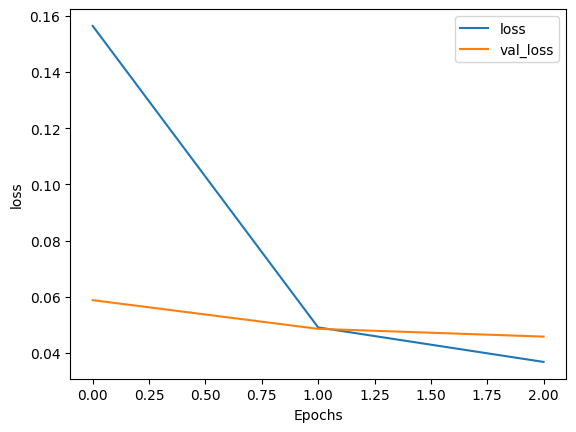

In [55]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [56]:
model.evaluate(x_test, np.array(y_test))

150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9849 - loss: 0.0494


[0.04754868522286415, 0.9854714870452881]

In [57]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:15}{:5}\t {}\n'.format('Word', 'True', 'Pred'))
print('-'*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{}\t{}'.format(words[w-1], tags[true], tags[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
Word           True 	 Pred

------------------------------
Pakistan       B-geo	B-geo
's             O	O
President      B-per	B-per
Asif           O	I-per
Ali            B-per	I-per
Zardari        I-per	I-per
is             O	O
meeting        O	O
Britain        B-geo	B-geo
's             O	O
Prime          B-per	B-per
Minister       O	I-per
David          B-per	I-per
Cameron        I-per	I-per
on             O	O
Thursday       B-tim	B-tim
for            O	O
the            O	O
first          O	O
time           O	O
since          O	O
the            O	O
British        B-gpe	B-gpe
leader         O	O
's             O	O
remarks        O	O
suggesting     O	O
that           O	O
Islamabad      B-geo	B-geo
is             O	O
promoting      O	O
"              O	O
the            O	O
export         O	O
of             O	O
terror         O	O
.              O	O
"              O	O
9.8            O	O
9.8            O	O
9.8            O	O
9.8            O	O
9.8     